In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from nilearn import image
from nilearn.glm.first_level import FirstLevelModel, make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix, plot_stat_map
from nilearn.interfaces.fmriprep import load_confounds
sys.path.append('..')
from utils.data import Subject, load_participant_list
from utils.analysis import compute_parametric_modulator

In [42]:
stim_rewards = {0: 0, 1: 1, 2: 2, 3: 2, 4: 3, 5: 3, 6: 4, 7: 4, 8: 5}
stim_frequ = {0: 0, 1: 0, 2: -1, 3: 1, 4: -1, 5: 1, 6: -1, 7: 1, 8: 0}

In [43]:
base_dir = '/Users/hugofluhr/data/LH_dev'
bids_dir = "/Users/hugofluhr/data/LH_dev/fmriprep-23.2.1"

sub_ids = load_participant_list(base_dir)

In [44]:
#subjects = [Subject(base_dir, sub_id, include_modeling=True, include_imaging=True, bids_dir=bids_dir) for sub_id in sub_ids]
subject = Subject(base_dir, '01', include_modeling=True, include_imaging=True, bids_dir=bids_dir)

# Setting parameters

In [45]:
tr = 2.33384
hrf_model = 'spm'
noise_model = 'ar1'
smoothing_fwhm = 5
high_pass = 0.01
motion_type = 'full'

run = 'learning1'
# ref to the block
block = getattr(subject, run)

# Get the data

In [46]:
np.corrcoef(block.extended_trials.first_stim_value_rl, block.extended_trials.first_stim_value_ck)[1, 0]

0.5804749453324884

In [47]:
columns_event = {'first_stim':'first_stim_presentation'}
events = block.extend_events_df(columns_event)
events['first_stim'] = events['first_stim'].astype(int)
events['first_stim_reward'] = events['first_stim'].map(stim_rewards)
events['first_stim_frequ'] = events['first_stim'].map(stim_frequ)

events.head(10)

,onset,duration,trial_type,trial,first_stim,first_stim_reward,first_stim_frequ
0,0.009399,0.817157,first_stim_presentation,1,7,4,1
1,0.826556,0.934432,second_stim_presentation,1,0,0,0
2,1.760988,0.000000,response,1,0,0,0
3,1.766016,1.569584,purple_frame,1,0,0,0
4,2.268539,1.067061,points_feedback,1,0,0,0
5,3.335600,6.675061,iti,1,0,0,0
6,10.010661,0.884950,first_stim_presentation,2,4,3,-1
7,10.895611,0.645392,second_stim_presentation,2,0,0,0
8,11.541003,0.000000,response,2,0,0,0
9,11.543884,1.857803,purple_frame,2,0,0,0


In [48]:
np.corrcoef(events.first_stim_reward, events.first_stim_frequ)[1, 0]

-0.04758479515628871

In [49]:
img_path = subject.img.get(run)
fmri_img = image.load_img(img_path)

In [50]:
confounds, sample_mask  = subject.load_confounds(run, motion_type=motion_type)

In [51]:
confounds.head(2)

,csf,rot_x,rot_x_derivative1,rot_x_derivative1_power2,rot_x_power2,rot_y,rot_y_derivative1,rot_y_derivative1_power2,rot_y_power2,rot_z,...,trans_z,trans_z_derivative1,trans_z_derivative1_power2,trans_z_power2,white_matter,cosine00,cosine01,cosine02,cosine03,cosine04
0,27.856635,-0.006275,0.001474,0.000001,9.795965e-07,-0.001482,0.000339,1.561292e-08,5.056087e-07,-0.001769,...,0.197327,0.037695,-0.00052,-0.109757,8.010894,0.070067,0.069900,0.069988,0.069599,0.069176
1,-6.503313,-0.004784,0.001474,0.000001,-8.256492e-06,-0.001140,0.000339,1.561292e-08,-2.012586e-07,-0.001838,...,0.234554,0.037695,-0.00052,-0.111133,3.195605,0.070064,0.069885,0.069955,0.069539,0.069082


# No parametric modulation

In [52]:
n = fmri_img.shape[-1]
frametimes = np.linspace(tr/2., (n - .5)*tr, n) # from Gilles, checked with nilearn FirstLevelModel

In [53]:
X1 = make_first_level_design_matrix(frame_times=frametimes,
                                    events=events,
                                    hrf_model=hrf_model,
                                    drift_model=None,
                                    high_pass=high_pass,
                                    add_regs=confounds)

/Users/hugofluhr/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
response.
  warnings.warn(
/Users/hugofluhr/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: first_stim, trial, first_stim_frequ, first_stim_reward
  warnings.warn(


In [54]:
model1 = FirstLevelModel(smoothing_fwhm=smoothing_fwhm)
model1 = model1.fit(fmri_img, design_matrices=X1, sample_masks=sample_mask)

# Plotting results

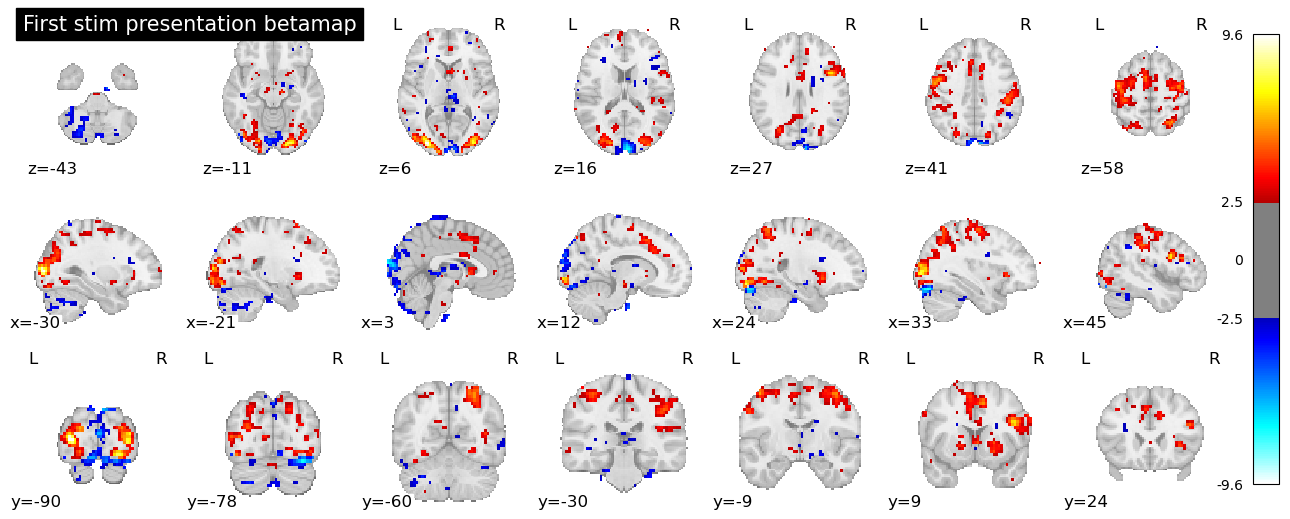

In [55]:
z_map1 = model1.compute_contrast(
    contrast_def="first_stim_presentation", output_type="z_score"
)

plot_stat_map(
    z_map1,
    threshold=2.5,
    display_mode="mosaic",
    title=f"First stim presentation betamap",
)

# Parametric modulation

In [69]:
condition = 'first_stim_presentation'

reg_reward = compute_parametric_modulator(events, condition, 'first_stim_reward',
                                            frametimes, hrf_model)
reg_frequ = compute_parametric_modulator(events, condition, 'first_stim_frequ',
                                            frametimes, hrf_model)

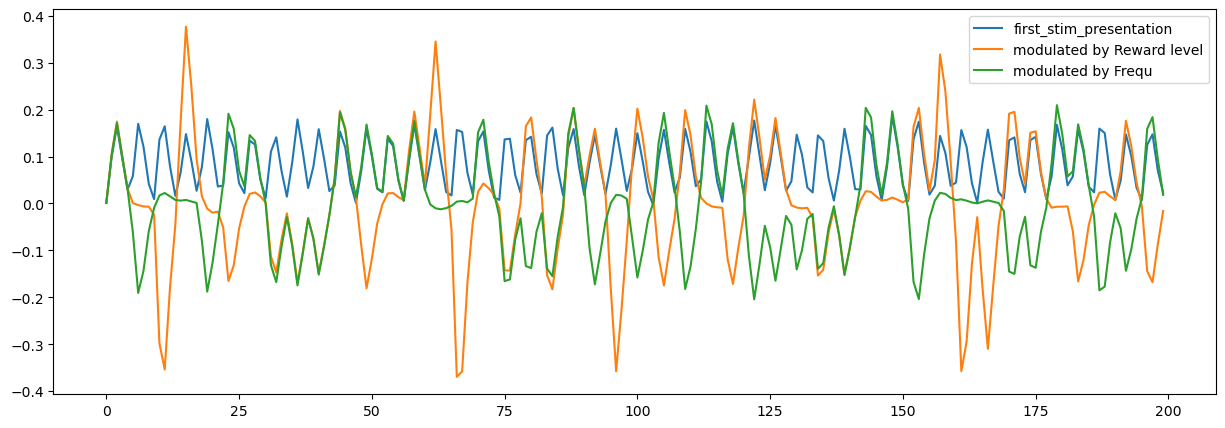

In [70]:
plt.figure(figsize=(15, 5))
plt.plot(X1[condition].values[:200], label=condition)
plt.plot(reg_reward[:200], label = 'modulated by Reward level') 
plt.plot(reg_frequ[:200], label = 'modulated by Frequ')
plt.legend()
plt.show()

In [71]:
np.corrcoef(reg_reward.ravel(), reg_frequ.ravel())[1, 0]

-0.026576081151505882

In [72]:
X_complete = X1.copy()
X_complete.insert(1, 'first_stim_reward', reg_reward)
X_complete.insert(2, 'first_stim_frequ', reg_frequ)

In [73]:
model2 = FirstLevelModel(smoothing_fwhm=smoothing_fwhm, minimize_memory=False)#, mask_img=bartra_mask_path)
model2 = model2.fit(fmri_img, design_matrices=X_complete, sample_masks=sample_mask)

# Plotting results

In [74]:
z_map_pres = model2.compute_contrast(
    contrast_def="first_stim_presentation", output_type="z_score"
)
z_map_reward = model2.compute_contrast(
    contrast_def="first_stim_reward", output_type="z_score"
)
z_map_frequ = model2.compute_contrast(
    contrast_def="first_stim_frequ", output_type="z_score"
)

In [75]:
np.corrcoef(z_map_pres.get_fdata().ravel(), z_map_reward.get_fdata().ravel())[1, 0]

0.033100944393461756

In [76]:
np.corrcoef(z_map_pres.get_fdata().ravel(), z_map_frequ.get_fdata().ravel())[1, 0]

0.16990160658133474

In [77]:
np.corrcoef(z_map_reward.get_fdata().ravel(), z_map_frequ.get_fdata().ravel())[1, 0]

0.05993202224453426

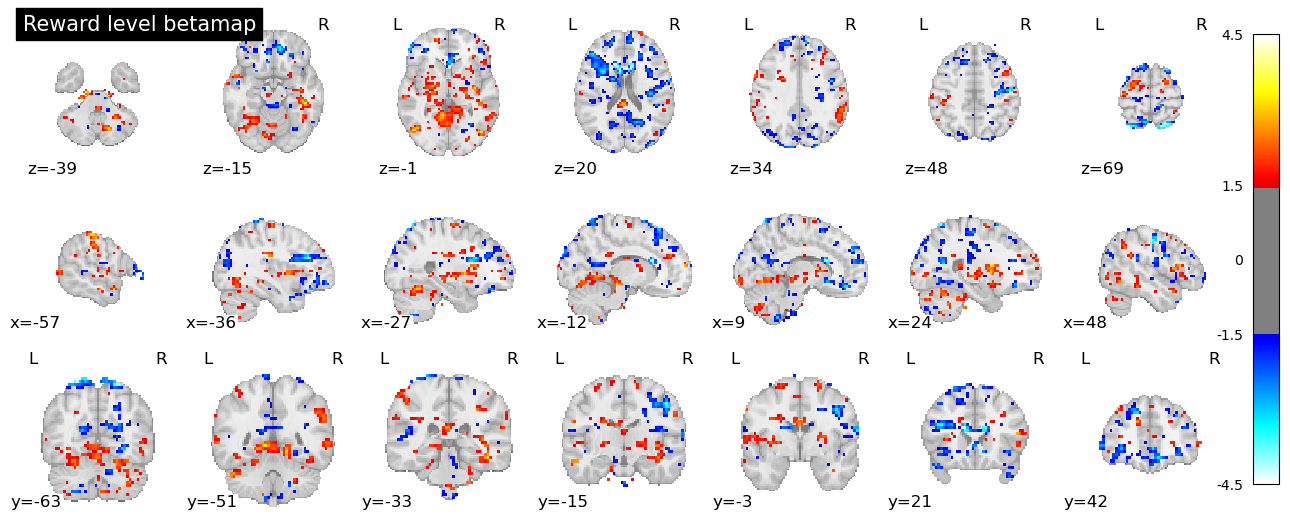

In [79]:
plot_stat_map(z_map_reward, threshold=1.5, display_mode="mosaic", title=f"Reward level betamap")

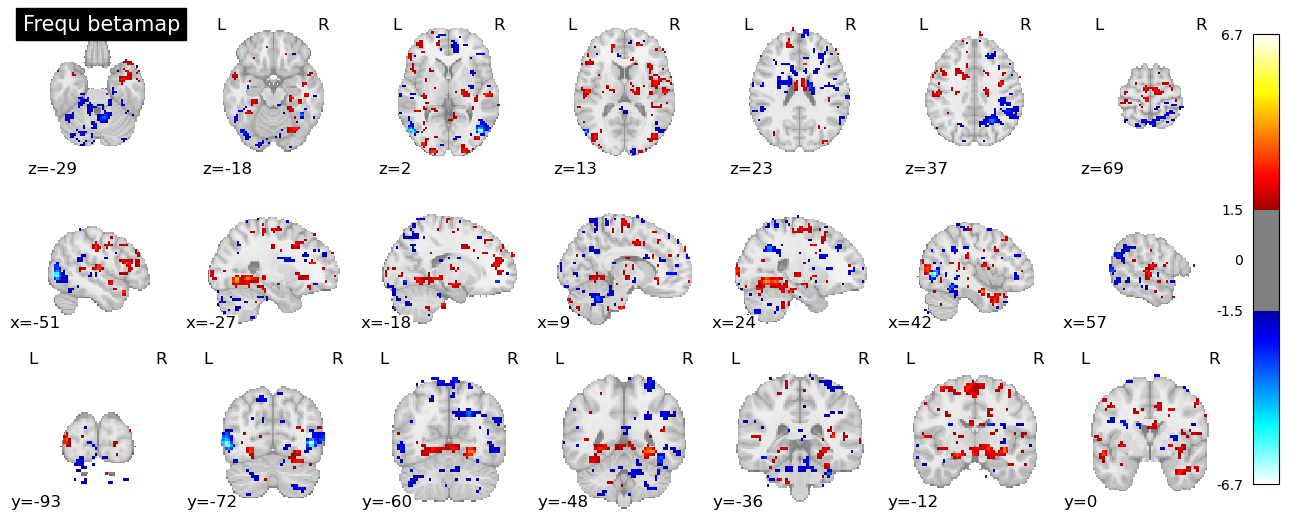

In [80]:
plot_stat_map(z_map_frequ, threshold=1.5, display_mode="mosaic", title=f"Frequ betamap")

# Split modeling of the 2 modulators

In [87]:
# Build the design matrix
X_reward = X1.copy()
X_reward.insert(1, 'first_stim_reward', reg_reward)

# Fit the first-level model
modelR = FirstLevelModel(smoothing_fwhm=smoothing_fwhm, minimize_memory=True)
modelR = modelR.fit(fmri_img, design_matrices=X_reward, sample_masks=sample_mask)

In [88]:
# Build the design matrix
X_frequ = X1.copy()
X_frequ.insert(1, 'first_stim_frequ', reg_frequ)

# Fit the first-level model
modelF = FirstLevelModel(smoothing_fwhm=smoothing_fwhm, minimize_memory=True)
modelF = modelF.fit(fmri_img, design_matrices=X_frequ, sample_masks=sample_mask)

In [94]:
z_map_pres_r = modelR.compute_contrast(
    contrast_def="first_stim_presentation", output_type="z_score"
)
z_map_pres_f = modelF.compute_contrast(
    contrast_def="first_stim_presentation", output_type="z_score"
)
z_map_reward_only = modelR.compute_contrast(
    contrast_def="first_stim_reward", output_type="z_score"
)
z_map_frequ_only = modelF.compute_contrast(
    contrast_def="first_stim_frequ", output_type="z_score"
)

In [91]:
np.corrcoef(z_map_pres.get_fdata().ravel(), z_map_pres_r.get_fdata().ravel())[1, 0]

0.9994928054633743

In [92]:
np.corrcoef(z_map_pres.get_fdata().ravel(), z_map_pres_f.get_fdata().ravel())[1, 0]

0.9989326091859492

In [93]:
np.corrcoef(z_map_pres_r.get_fdata().ravel(), z_map_pres_f.get_fdata().ravel())[1, 0]

0.9983143369501213

In [95]:
np.corrcoef(z_map_reward.get_fdata().ravel(), z_map_reward_only.get_fdata().ravel())[1, 0]

0.9993662423316388

In [96]:
np.corrcoef(z_map_frequ.get_fdata().ravel(), z_map_frequ_only.get_fdata().ravel())[1, 0]

0.999221023810938

In [97]:
np.corrcoef(z_map_reward_only.get_fdata().ravel(), z_map_frequ_only.get_fdata().ravel())[1, 0]

-0.013584044913011798

## Results of splitting models
Despite fitting models separately, the correlation between the beta maps of the RL and CK modulations remains really high, especially in the Test run